Daniel Pflueger: d.pfluger@uu.nl

Jasper de Jong: j.dejong3@uu.nl

Licensed under *Creative Commons - Attribution-NonCommercial-ShareAlike 4.0 International* [(CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import expected_fields as xf
import norm_const_fit as nc
import geo_tools as gt
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

# Pre-processing of data

In a first step, we must obtain the fields out of which we create expected fields for later scaling. Usually we look at the difference field $\Delta F$ between a control and a geoengineering run, i.e. $\Delta F = F_{\mathrm{geo}} - F_{\mathrm{cnt}}$ where  $F_{\mathrm{geo}}$ and $F_{\mathrm{cnt}}$ are the field values in the geoengineering and control run respectively.

To have `xarray` compute a sensible difference between the two fields, we must ensure that they have the same time axis. There are two options to do this:
* Resample both fields/datasets to a common time axis (e.g. daily)
* Interpolate one of the fields/datasets to the time axis of the other

Both approaches are convenient to implement in `xarray` but the first might take up a lot of space because of the daily interpolation. I will therefore interpolate to the time axis of the geoengineering run.

In [2]:
%%time 
#%%timeit
# -> 652 ms ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# Very fast considering ~3GB input files.
# Note that the difference operation ds_diff = ds_geo - ds_cnt is postponed by dask

# Loading WACCM data
# path_sim is only used for checking consistency, otherwise it is not needed
# ! Edit the paths to your file paths !
path_cnt = "../WACCM/ozone_strataero1mode_B5505C5WCCML45BGCR.f09_g16.control.EM1-20_month_1_c20211115.nc"
path_geo = "../WACCM/ozone_strataero1mode_b.e15.B5505C5WCCML45BGCR.f09_g16.feedback.EM1-20_month_1_c20211103.nc"
path_sim = "../WACCM/b.e15.B5505C5WCCML45BGCR.f09_g16.feedback.ozone_strataero1mode_2075_2095_1.nc"

# Chunking/dask enabled for better performance
ds_geo_total = xr.open_dataset(path_geo,chunks={'lat':-1, 'lev':-1, 'time': 400})
ds_cnt_total = xr.open_dataset(path_cnt,chunks={'lat':-1, 'lev':-1, 'time': 400})
ds_sim_total = xr.open_dataset(path_sim,chunks={'lat':-1, 'lev':-1, 'time': 400}) # Simone's data, used for correcting shift in time coordinate

# Fixing time shift of ~15 days in cnt & geo
shift = lambda t: xr.DataArray(data=[ti.replace(day=1,hour=0) for ti in t.data], coords=t.coords, dims=t.dims, attrs=t.attrs)
ds_cnt_total = ds_cnt_total.assign_coords(time=shift(ds_cnt_total.time))
ds_geo_total = ds_geo_total.assign_coords(time=shift(ds_geo_total.time))

# Quality checks
check1 = ds_cnt_total.sel(time=slice('2020','2030')).time.data == ds_geo_total.sel(time=slice('2020','2030')).time.data
check2 = ds_geo_total.sel(time=slice('2075','2095')).time.data == ds_sim_total.sel(time=slice('2075','2095')).time.data
print(f"Time stamps of geo and cnt from 2020-2030 match: {all(check1) and len(check1)>0}")
print(f"Time stamps of geo and sim from 2075-2095 match: {all(check2) and len(check2)>0}")

# Constrain data to 2020 to 2100 because there is a discontinuity afterwards
ds_geo = ds_geo_total.sel(time=slice('2020','2099'))

# Calculate interannual average control data over 2020-2030 and extrapolate to 2100
# Strictly this only works if there is no trend, which is almost true for the important variables
ds_cnt_avg = ds_cnt_total.sel(time=slice('2020','2030')).groupby('time.dayofyear').mean()
ds_cnt = ds_geo.copy()
n_years = len(np.unique(ds_cnt.time.dt.year.data))
aux = ['P0','PS','date','date_written','datesec','gw','hyai','hyam','hybi','hybm','ilev','lat','lev',
       'mdt','nbdate','nbsec','ndbase','ndcur','nsbase','nscur','nsteph','time','time_bnds','time_written']
for var in ds_cnt.variables:
    if ('time' in ds_cnt[var].dims) and (var not in aux): #['datesec','ndcur','nscur','nsteph','date','date_written','time','time_bnds','time_written']
        ds_cnt[var].data = np.tile(ds_cnt_avg[var].data, (n_years,)+(len(ds_cnt_avg[var].dims)-1)*(1,))

<timed exec>:14: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 400. This could degrade performance. Instead, consider rechunking after loading.


Time stamps of geo and cnt from 2020-2030 match: True
Time stamps of geo and sim from 2075-2095 match: True
CPU times: user 1.84 s, sys: 237 ms, total: 2.07 s
Wall time: 2.1 s


The control data is available until 2030 and is extended by the (2020-2030) mean. Results of this extension are shown below.

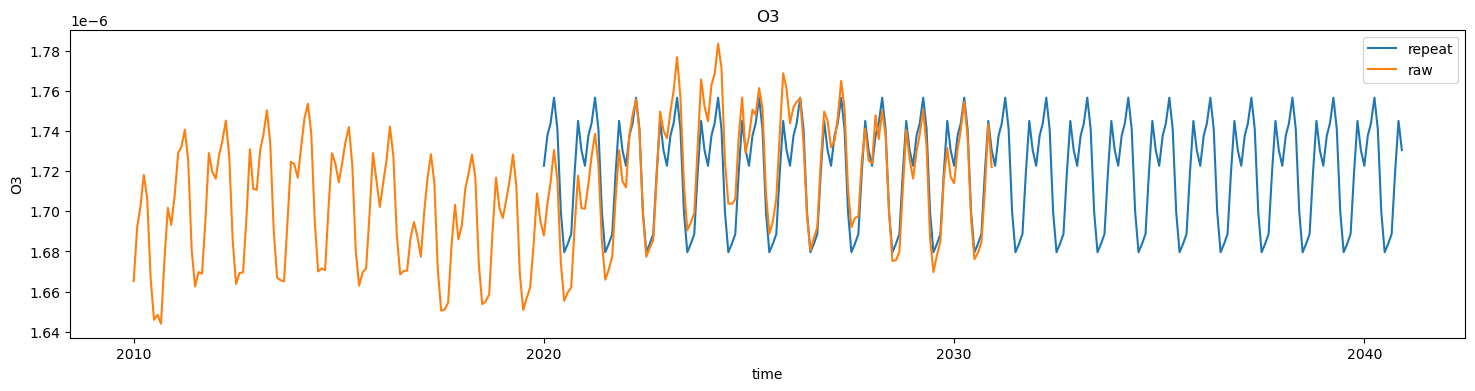

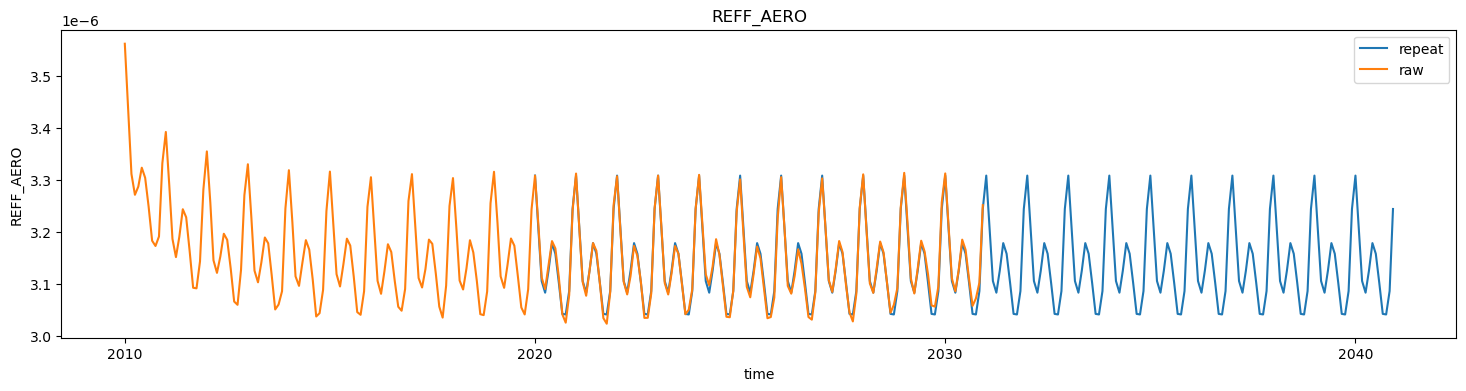

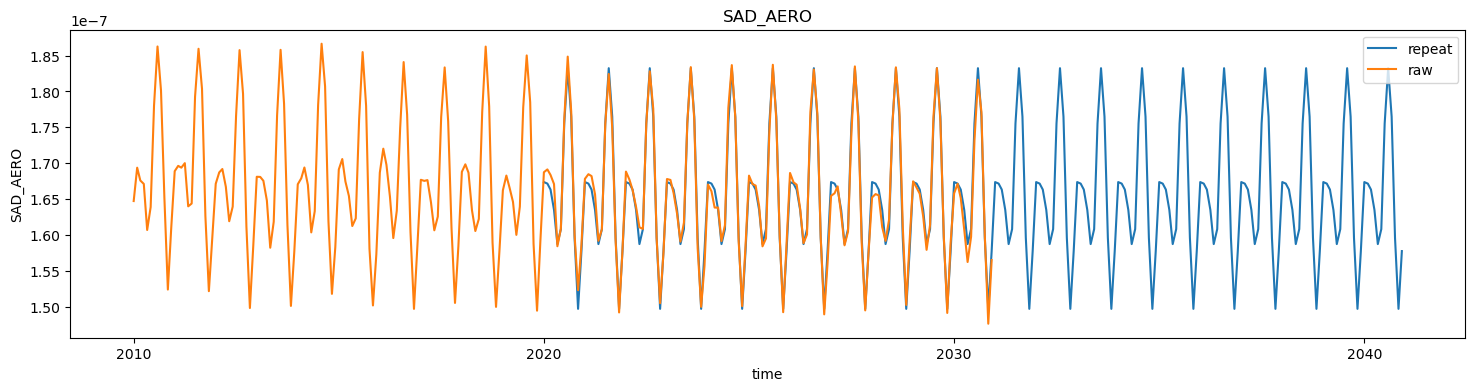

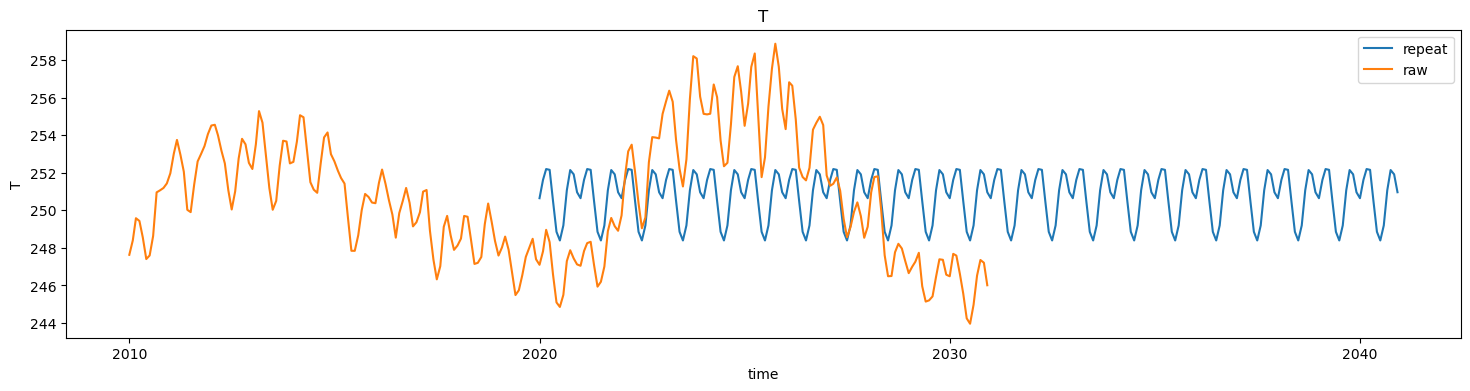

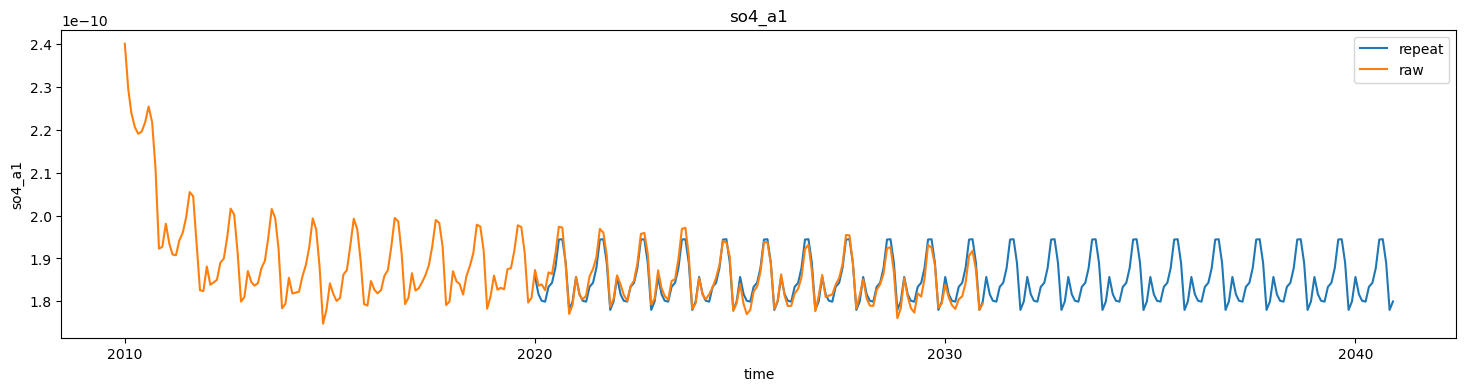

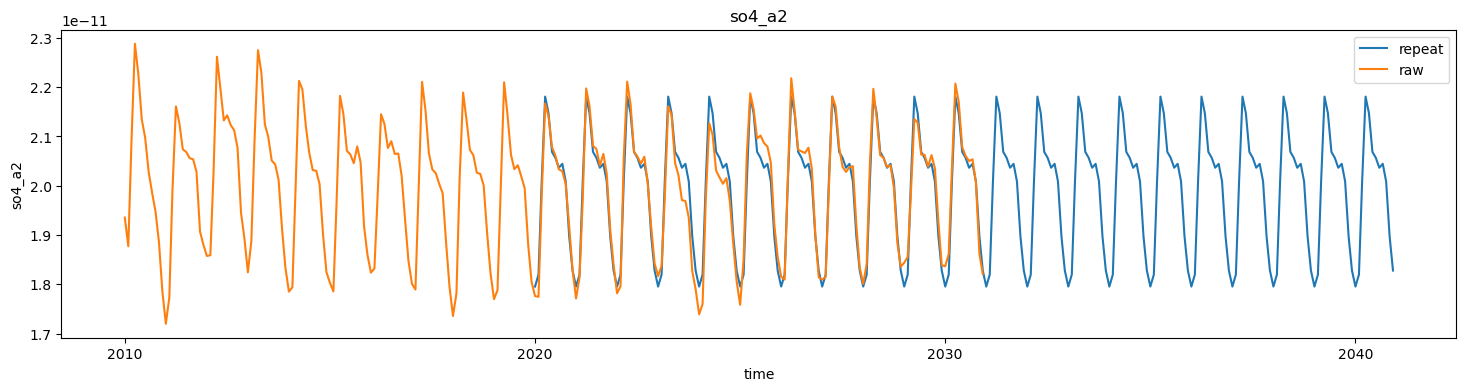

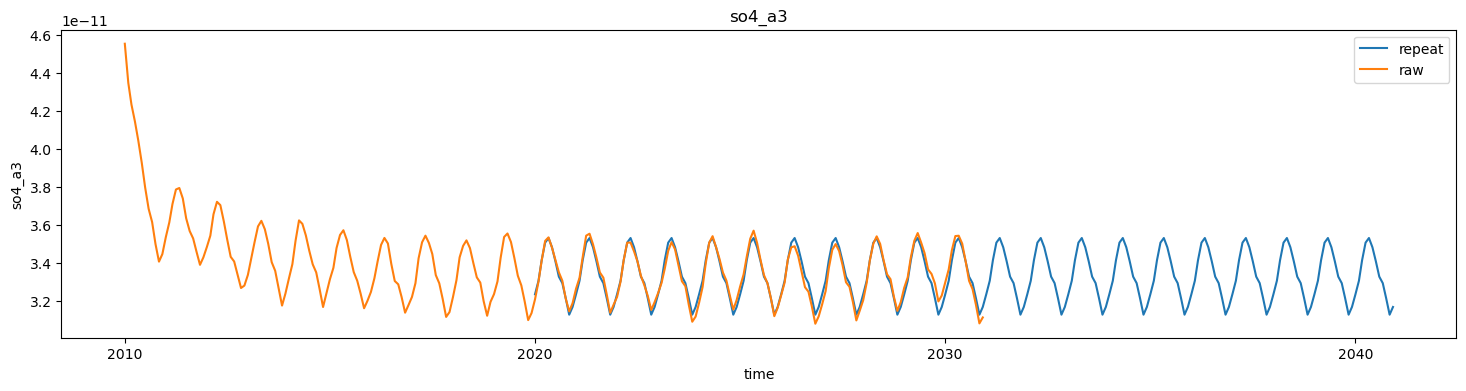

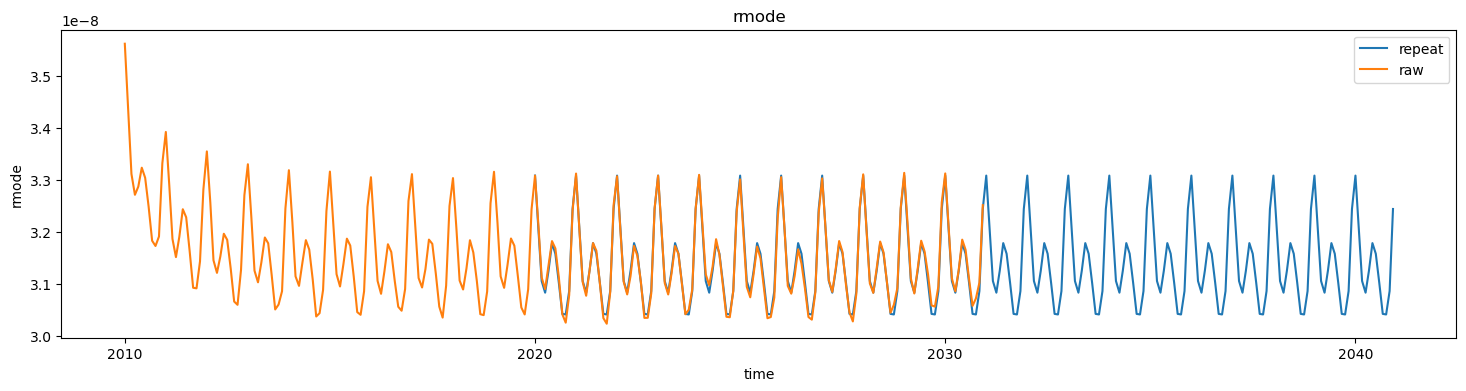

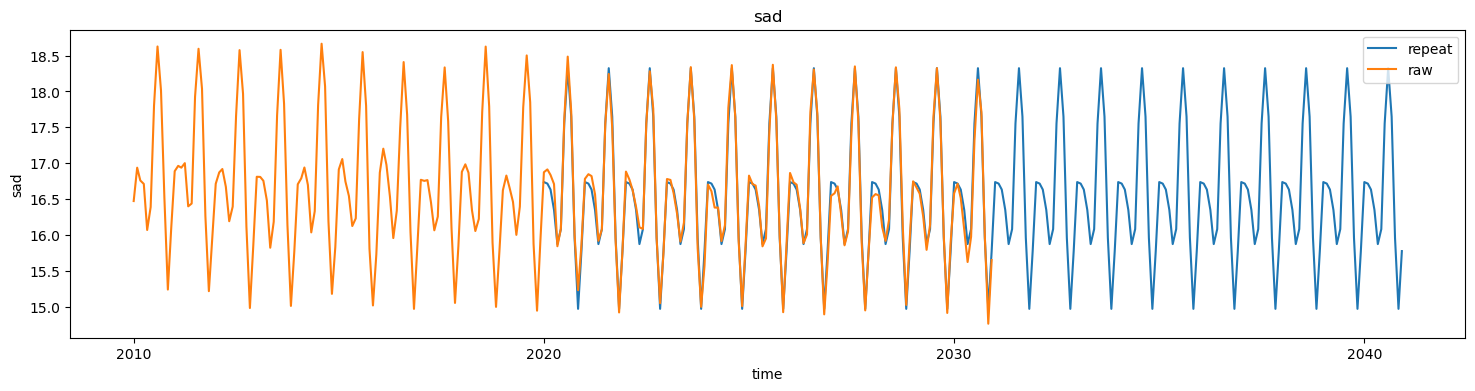

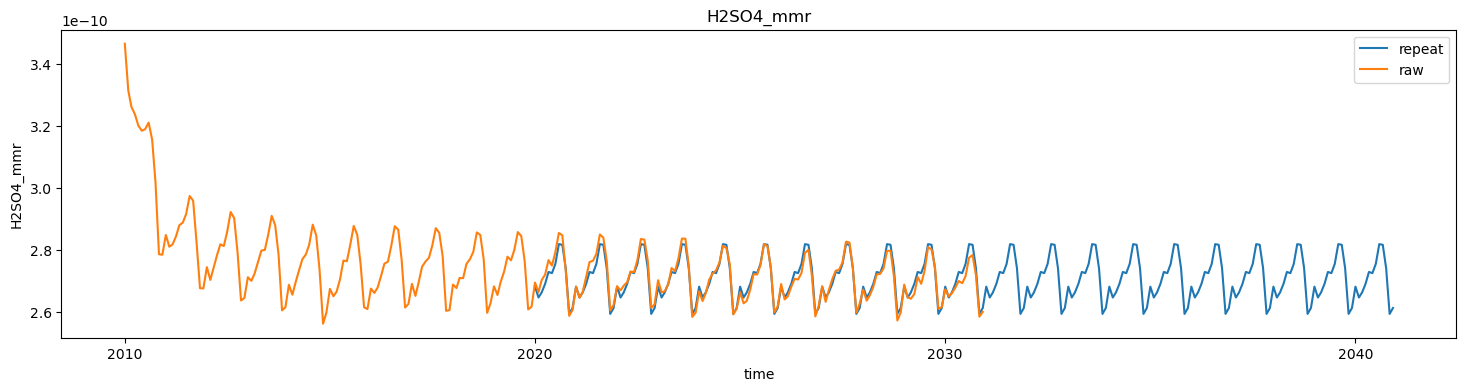

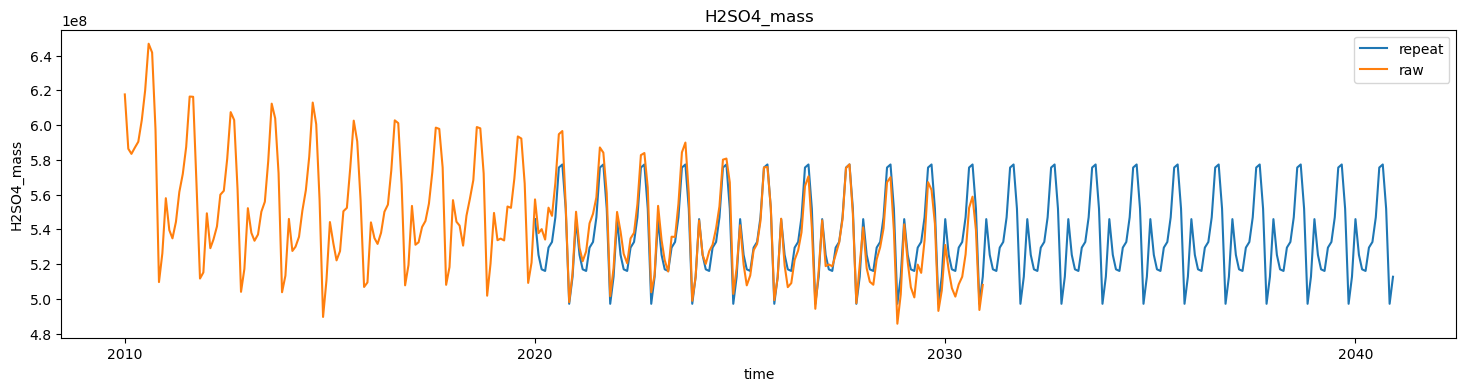

In [3]:
for var in ds_cnt_total.variables:
    if len(ds_cnt_total[var].dims)==3:
        plt.figure(figsize=(18,4))
        ds_cnt[var].sel(time=slice('2010','2040')).mean(dim=['lat','lev']).plot(label='repeat')
        ds_cnt_total[var].sel(time=slice('2010','2040')).mean(dim=['lat','lev']).plot(label='raw')
        plt.title(var)
        plt.legend()

In [4]:
# this takes the difference over all variables in the datasets
# excluding the ones we don't want to modify! 
ds_diff = ds_geo.copy()
for var_name in ds_geo.variables:
    if var_name not in aux:
        ds_diff[var_name].data = ds_geo[var_name].data - ds_cnt[var_name].data

Text(0, 0.5, 'kg/kg')

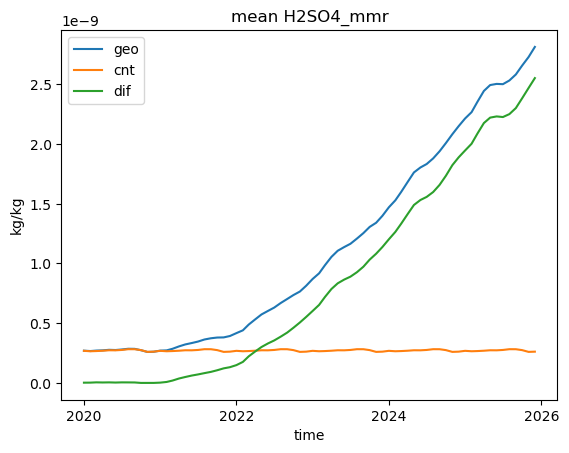

In [5]:
# checking the difference dataset (GEO - CNT)
time_sel = slice('2020','2025')
ds_geo.H2SO4_mmr.sel(time=time_sel).mean(dim=['lat','lev']).plot(label='geo')
ds_cnt.H2SO4_mmr.sel(time=time_sel).mean(dim=['lat','lev']).plot(label='cnt')
ds_diff.H2SO4_mmr.sel(time=time_sel).mean(dim=['lat','lev']).plot(label='dif')
plt.legend()
plt.title('mean H2SO4_mmr')
plt.ylabel(ds_geo.H2SO4_mmr.units)

# Building an expected field

To build an expected field, we need only four things:
* The dataset of the difference data
* The name of the field we want to create an expected field for
* Time boundaries $t_i$, $t_f$ such that the averaging is done for years $t$: $t_i<t<t_f$
* The normalizing function we want to use, e.g. `xf.int_mass` for the `so4mass_a3` field

These are the arguments used in `xf.build_expected_field`. The output of the function is a dictionary with the keywords
* `"exp_field"`: a DataArray with dayofyear time coordinates describing the expected field
* `"n"`: the annual normalization constants as DataArray with integer year time coordinates
* `"nday"`: the daily normalization constants of the original field with original time coordinates

In the following examples, I will use 2070-2100 as the averaging period.

The output can be interpreted in the following way:
* `field` is the original forcing field(year,day,lat) 
* `nday` is some scalar value for each time (year,day) that normalizes the field data
* `n` is the intra-annual mean of `nday`, thus having shape (year)
* `exp_field = <field/n>` is the daily mean normalized field of shape (day,lat)

## Mass field

Use `xf.int_mass` as normalization function. 

Note that when you are using a difference dataset, you can not uniquely determine the pressure levels so there is still some degree of arbitrariness to the result.

In [9]:
#%%timeit
#->2.2 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# res_mass = xf.build_expected_field(ds_diff,'so4mass_a3',[2070,2100],
#                                   norm=xf.int_mass)

In [10]:
# (res_mass['n']/10**9).plot()
# plt.ylabel('Aerosol mass a3 mode [Tg SO4]')

In [11]:
# res_mass['exp_field'].isel(dayofyear=0).plot()

## AOD field example

Here the AOD field is analysed to get the normalisation constants and expected fields using `norm = xf.int_aod`.

In [12]:
res_aod = xf.build_expected_field(ds_diff,'AODVISstdn',[2070,2100],
                                  norm=xf.int_aod)

Text(0.5, 1.0, '$n_{\\mathrm{AOD}}$')

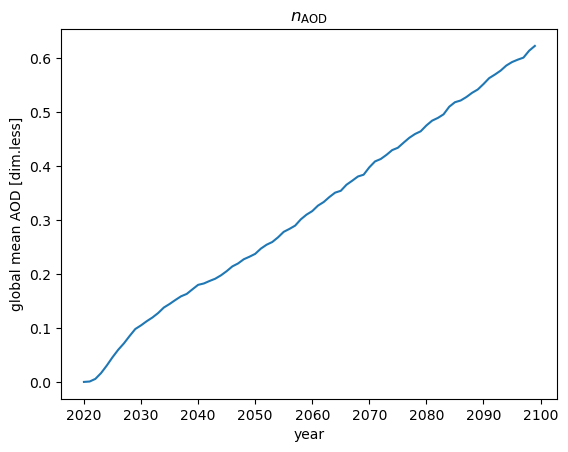

In [13]:
res_aod['n'].plot()
plt.ylabel('global mean AOD [dim.less]')
plt.title("$n_{\mathrm{AOD}}$")

Text(0, 0.5, '$\\mathrm{AOD}/n_{\\mathrm{AOD}}$')

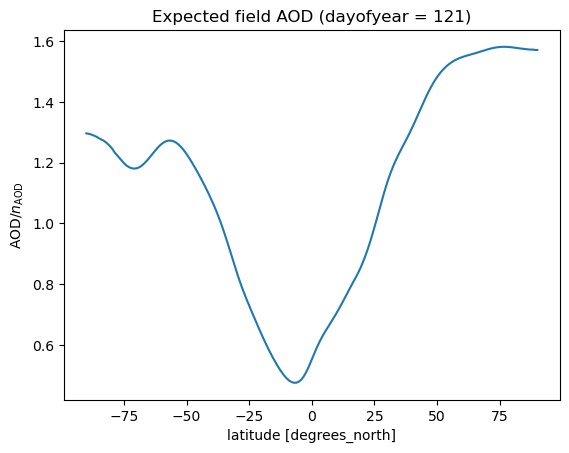

In [14]:
data = res_aod['exp_field'].isel(dayofyear=4)
data.plot()
plt.title(f'Expected field AOD (dayofyear = {data.dayofyear.item()})')
plt.ylabel("$\mathrm{AOD}/n_{\mathrm{AOD}}$")

## Other fields (general integration rule) example

For a general field with lev/lat dimensions, the function `xf.int_l2_lev` can be used as a normalizer. It is the default `norm` argument of `xf.build_expected_field`. Here I use the field `diamwet_a3` as an example.

In [15]:
name = f'so4_a3'
res_general = xf.build_expected_field(ds_diff,name,[2070,2100])

Text(0.5, 1.0, '$n_{\\mathrm{so4\\_a3}}$')

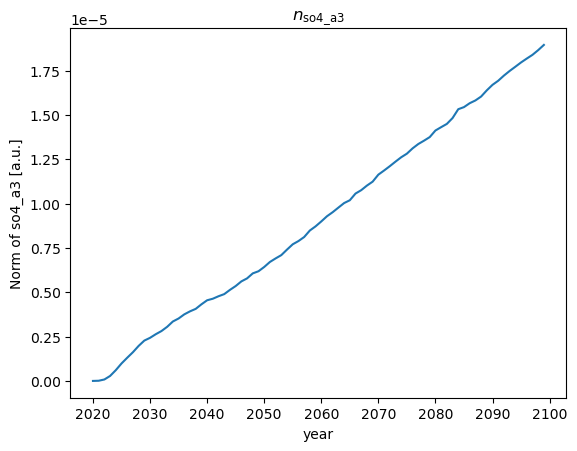

In [16]:
res_general['n'].plot()
plt.ylabel(f'Norm of {name} [a.u.]')
plt.title("$n_{\mathrm{so4\_a3}}$")

Text(0, 0.5, 'lev [hPa]')

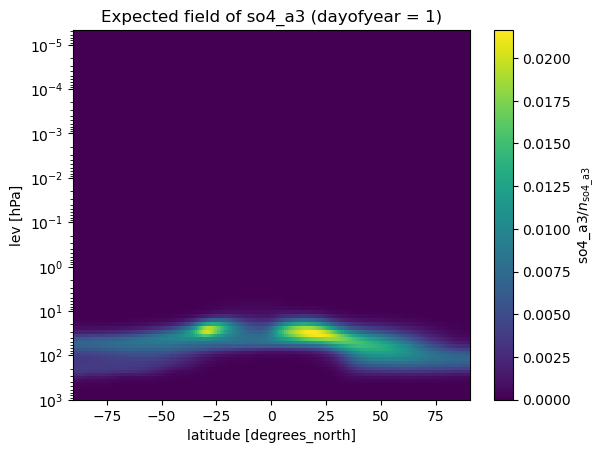

In [17]:
data = res_general['exp_field'].isel(dayofyear=0)
data.plot(yscale='log', yincrease=False, cbar_kwargs={'label':'so4_a3/$n_{\mathrm{so4\_a3}}$'})
plt.title(f'Expected field of so4_a3 (dayofyear = {data.dayofyear.item()})')
plt.ylabel('lev [hPa]')

## Testing different norms

The goal is finding a norm that is as smooth as possible and monotonically increasing

In [18]:
print(list(ds_diff.variables))

['AODVISstdn', 'O3', 'P0', 'PS', 'REFF_AERO', 'SAD_AERO', 'T', 'ch4vmr', 'co2vmr', 'date', 'date_written', 'datesec', 'f11vmr', 'f12vmr', 'gw', 'hyai', 'hyam', 'hybi', 'hybm', 'ilev', 'lat', 'lev', 'mdt', 'n2ovmr', 'nbdate', 'nbsec', 'ndbase', 'ndcur', 'nsbase', 'nscur', 'nsteph', 'so4_a1', 'so4_a2', 'so4_a3', 'sol_tsi', 'time_bnds', 'time_written', 'rmode', 'sad', 'H2SO4_mmr', 'H2SO4_mass', 'time']


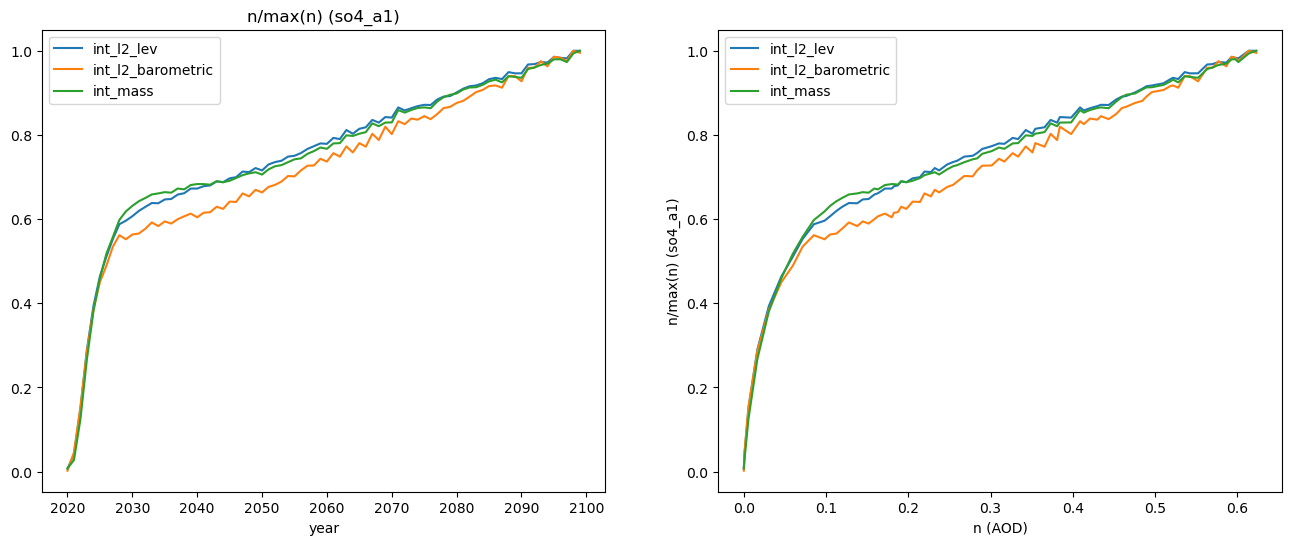

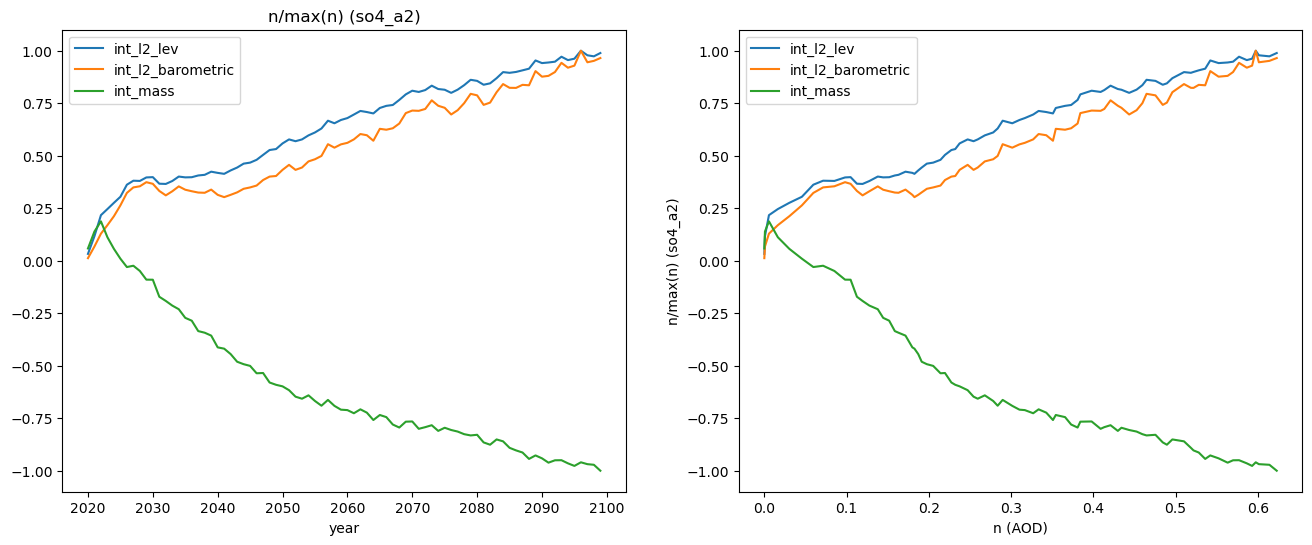

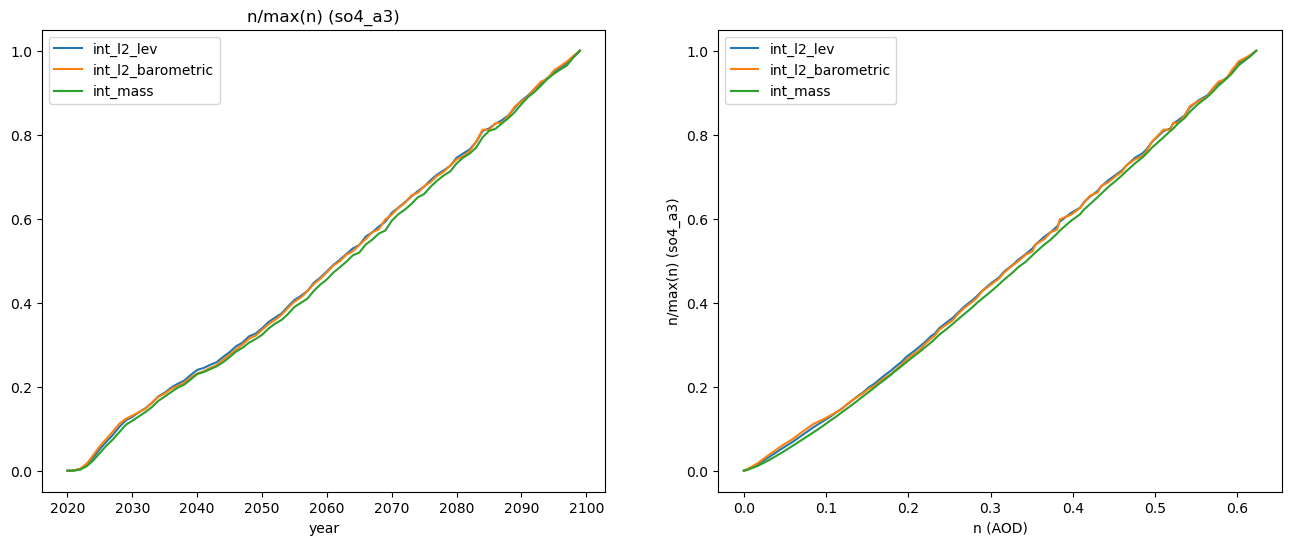

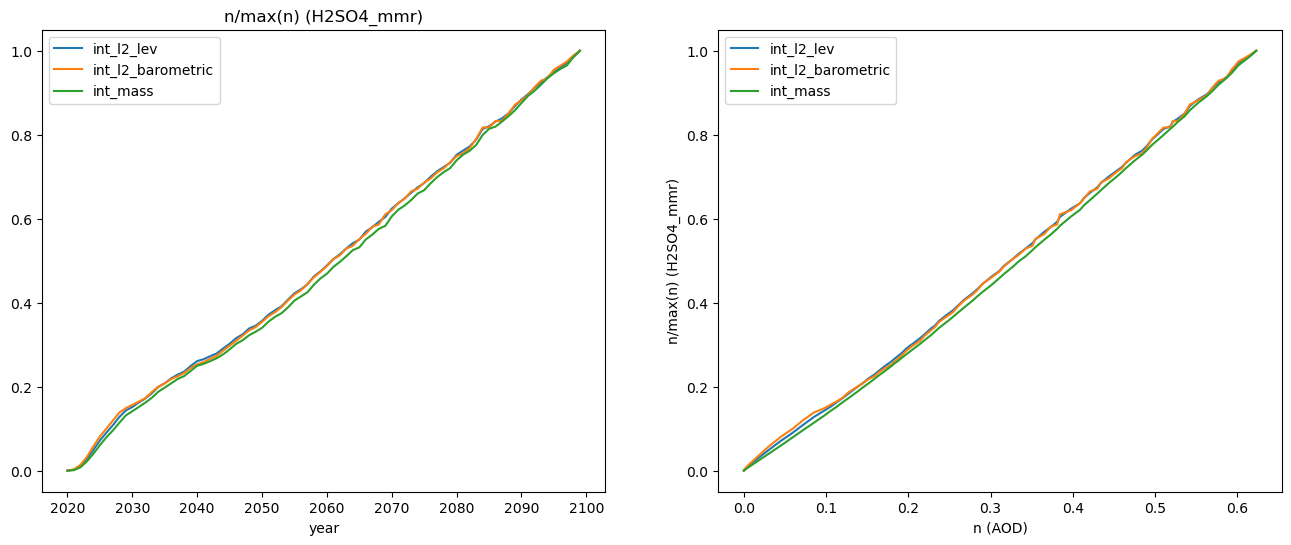

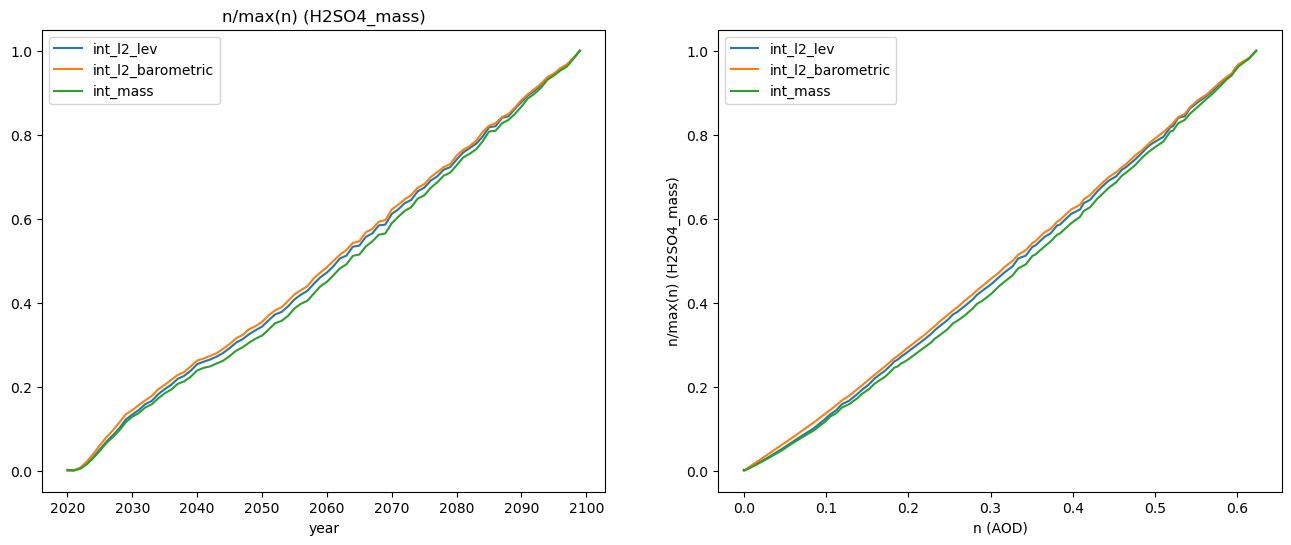

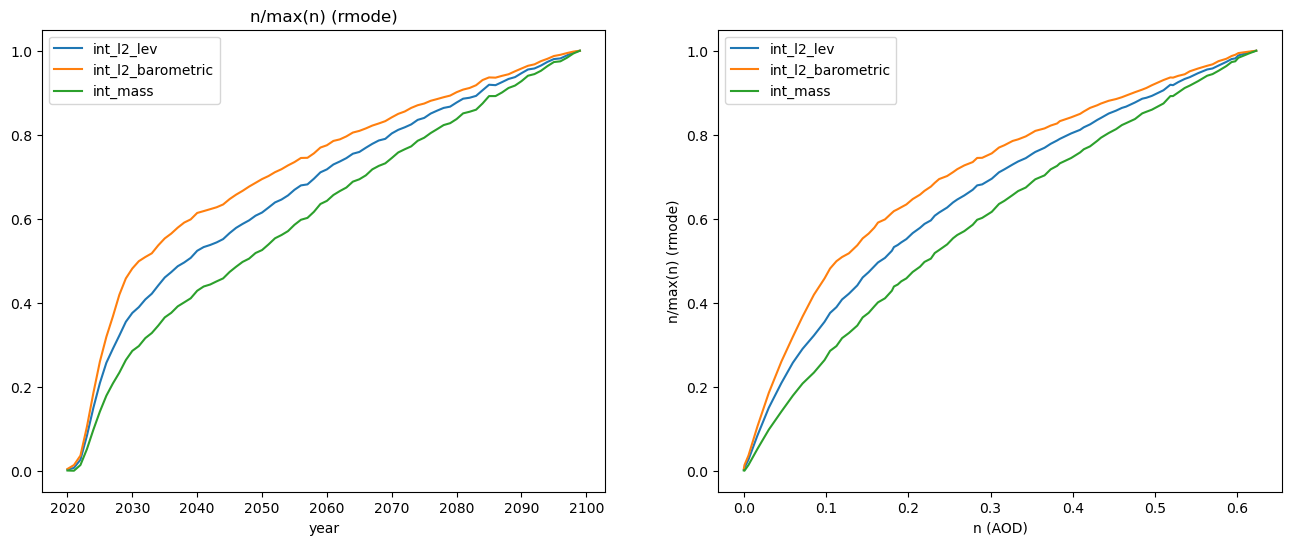

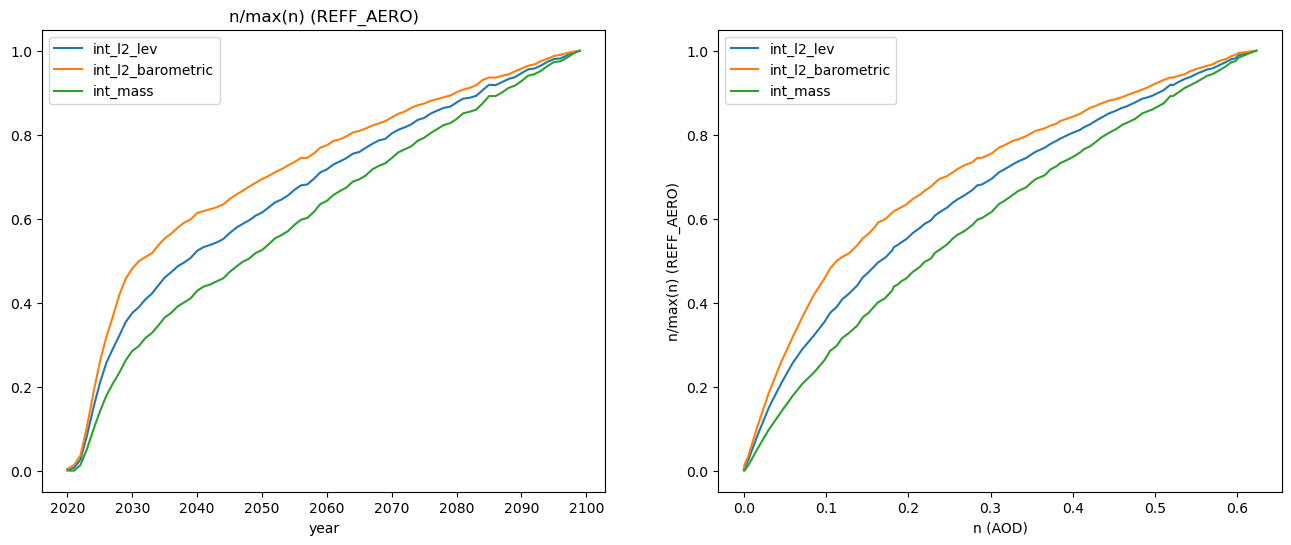

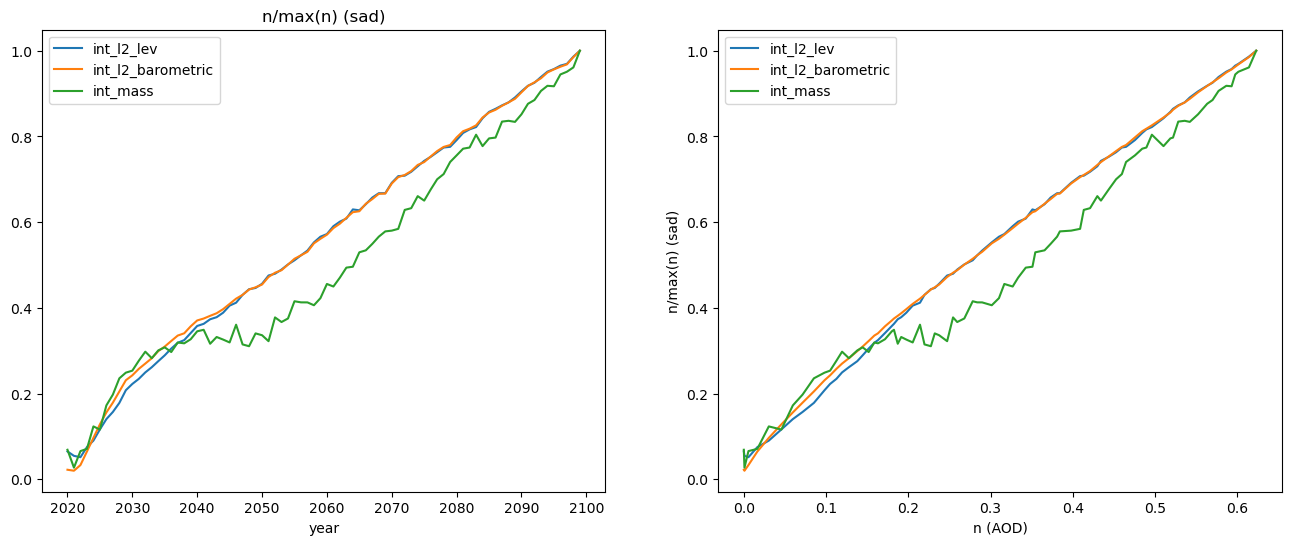

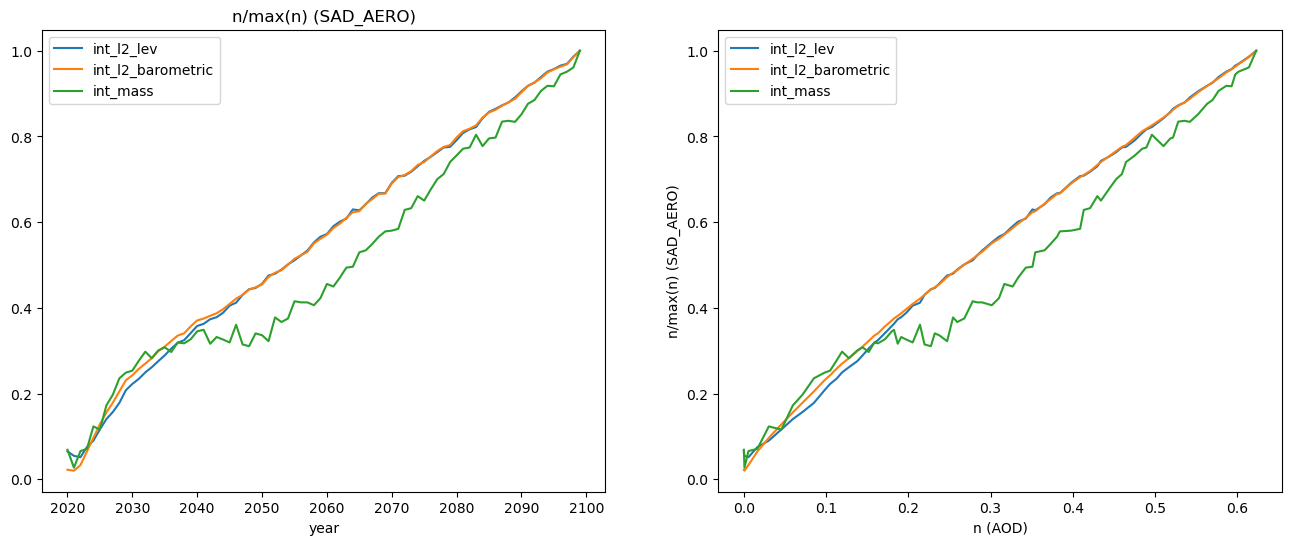

In [19]:
# show normalisation factors for all variables using three methods

# varname = "H2SO4_mmr" # ['REFF_AERO','SAD_AERO','so4_a1','so4_a2','so4_a3','rmode','sad','H2SO4_mmr','H2SO4_mass']
for varname in ['so4_a1','so4_a2','so4_a3','H2SO4_mmr','H2SO4_mass','rmode','REFF_AERO','sad','SAD_AERO']:
    key = "n" # ['n','nday']
    cdict0 = xf.build_expected_field(ds_diff, 'AODVISstdn', [2070,2100], norm=xf.int_aod)
    cdict1 = xf.build_expected_field(ds_diff, varname, [2070,2100], norm=xf.int_l2_lev)
    cdict2 = xf.build_expected_field(ds_diff, varname, [2070,2100], norm=xf.int_l2_barometric)
    cdict3 = xf.build_expected_field(ds_diff, varname, [2070,2100], norm=xf.int_mass)
    n1 = cdict1[key] / abs(cdict1[key]).max() # for better comparison
    n2 = cdict2[key] / abs(cdict2[key]).max() 
    n3 = cdict3[key] / abs(cdict3[key]).max()

    fig, ax = plt.subplots(1,2,figsize=(16,6))
    n1.plot(ax=ax[0], label='int_l2_lev')
    n2.plot(ax=ax[0], label='int_l2_barometric')
    n3.plot(ax=ax[0], label='int_mass')
    ax[0].set_title(f"{key}/max({key}) ({varname})")
    ax[0].legend()

    ax[1].plot(cdict0[key], n1, label='int_l2_lev')
    ax[1].plot(cdict0[key], n2, label='int_l2_barometric')
    ax[1].plot(cdict0[key], n3, label='int_mass')
    ax[1].set_xlabel('n (AOD)')
    ax[1].set_ylabel(f"n/max(n) ({varname})")
    ax[1].legend()
    
    plt.show()

### For each variable, save the expected field

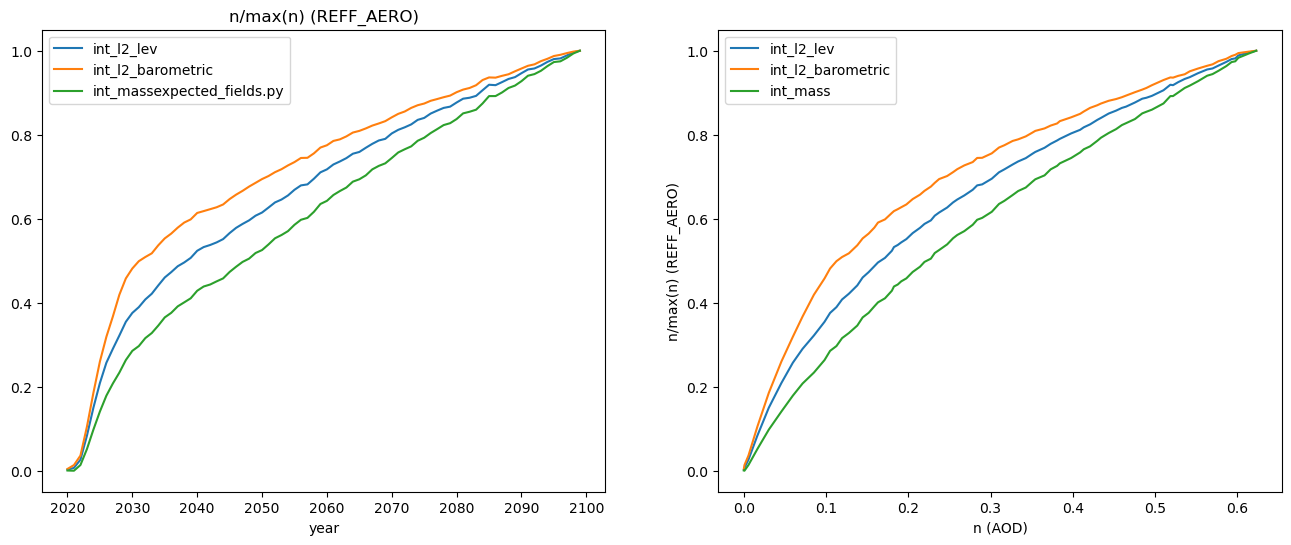

Data directory ./exp_fields_jasper_02/REFF_AERO/ found. Possibly overwriting data.


In [20]:
# Run this cell for each variable
# Pick the 'best' cdict and save expected field

varname = "REFF_AERO" # choose from ['REFF_AERO','SAD_AERO','so4_a1','so4_a2','so4_a3',
    # 'rmode','sad','H2SO4_mmr','H2SO4_mass','AODVISstdn']
savepath = "./exp_fields_jasper_02/" # edit file path where results are stored
# exp_fields_jasper_01 has been used for the CESM1 runs
# exp_fields_jasper_02 is a more recent copy of exp_fields_jasper_01 (pickled objects are sensitive to environment changes)
key = "n" # ['n','nday'] for plotting only

cdict0 = xf.build_expected_field(ds_diff, 'AODVISstdn', [2070,2100], norm=xf.int_aod)
cdict1 = xf.build_expected_field(ds_diff, varname, [2070,2100], norm=xf.int_l2_lev)
cdict2 = xf.build_expected_field(ds_diff, varname, [2070,2100], norm=xf.int_l2_barometric)
cdict3 = xf.build_expected_field(ds_diff, varname, [2070,2100], norm=xf.int_mass)
n1 = cdict1[key] / abs(cdict1[key]).max() # for better comparison
n2 = cdict2[key] / abs(cdict2[key]).max() 
n3 = cdict3[key] / abs(cdict3[key]).max()

fig, ax = plt.subplots(1,2,figsize=(16,6))
n1.plot(ax=ax[0], label='int_l2_lev')
n2.plot(ax=ax[0], label='int_l2_barometric')
n3.plot(ax=ax[0], label='int_massexpected_fields.py')
ax[0].set_title(f"{key}/max({key}) ({varname})")
ax[0].legend()

ax[1].plot(cdict0[key], n1, label='int_l2_lev')
ax[1].plot(cdict0[key], n2, label='int_l2_barometric')
ax[1].plot(cdict0[key], n3, label='int_mass')
ax[1].set_xlabel('n (AOD)')
ax[1].set_ylabel(f"n/max(n) ({varname})")
ax[1].legend()

plt.show()

# save expected field
xf.save_exp(cdict3,savepath) # insert the 'best' cdict here

# Used settings:
# AODVISstdn: cdict0 - xf.int_aod
# H2SO4_mass: cdict3 - xf.int_mass
# H2SO4_mmr: cdict3 - xf.int_mass
# REFF_AERO: cdict3 - xf.int_mass
# rmode: cdict3 - xf.int_mass
# sad: cdict1 - xf.int_l2_lev
# SAD_AERO: cdict1 - xf.int_l2_lev
# so4_a1: cdict3 - xf.int_mass
# so4_a2: cdict1 - xf.int_l2_lev
# so4_a3: cdict3 - xf.int_mass

### For each variable, determine the fit parameters

Fits are determined over data from 2050 to 2100 only (roughly corresponding to n_AOD > 0.23)

In [21]:
# load expected fields and normalisation factors from disk

loadpath = savepath
exp_fields_dict = xf.load_exp(loadpath)

In [22]:
# fit normalisation factors

names = list(exp_fields_dict)
names.remove("AODVISstdn")
P0 = { # Initial guess parameter
    "H2SO4_mass": [1e29, 2e29, 1e0],
    "H2SO4_mmr": [8e8, 2e11, 1e0],
    "REFF_AERO": [-7e12,1e14,6e-1],
    "SAD_AERO": [7e-6,1e-4,9e-1], 
    "rmode": [-6e10,1e12,6e-1], 
    "sad": [7e2, 1e4, 1], 
    "so4_a1": [1e9,3e9,3e-1],
    "so4_a2": [-3e8, 5e-8, 2e-1], 
    "so4_a3": [1e15, 1e15, 2e0] 
    }

options={name:{"tbounds":(2050,2100), "p0":P0[name]} for name in P0} 
# fit_func not given, defaults to nc.fit_func_power_law => n = a + b * n_aod ** c
fit_dict = nc.fit_norm_const(exp_fields_dict, "AODVISstdn", options)

print("name      : [c0, c1, c2]")
for name in sorted(fit_dict):
    print(f"{name:10}: {fit_dict[name]['popt']}")

name      : [c0, c1, c2]
H2SO4_mass: [-3.16490727e+26  1.38754083e+29  1.16797461e+00]
H2SO4_mmr : [7.77615898e+08 1.97858396e+11 1.13329203e+00]
REFF_AERO : [-6.66015324e+12  1.25928805e+14  6.03564698e-01]
SAD_AERO  : [6.90016881e-06 1.42043172e-04 9.05755643e-01]
rmode     : [-6.66015265e+10  1.25928805e+12  6.03564703e-01]
sad       : [6.90017122e+02 1.42043170e+04 9.05755680e-01]
so4_a1    : [1.71717957e+09 3.81491279e+09 6.56064609e-01]
so4_a2    : [-3.04225049e-08  4.86393083e-08  1.60519311e-01]
so4_a3    : [-1.37374205e+09  1.70837673e+11  1.14287289e+00]


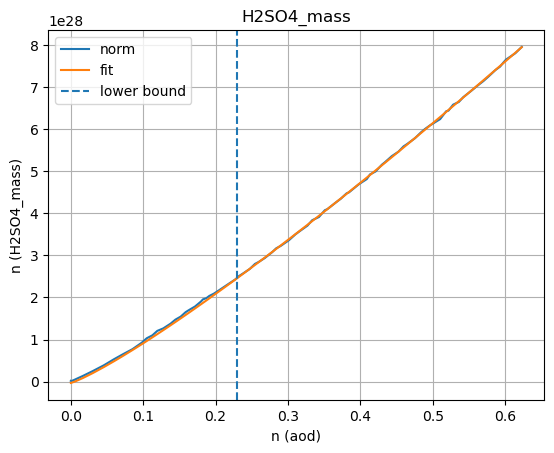

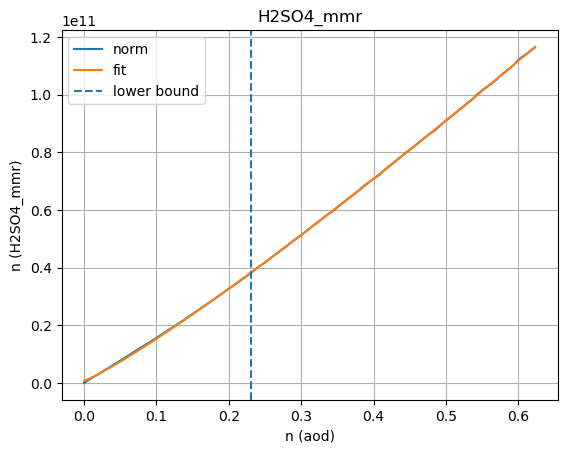

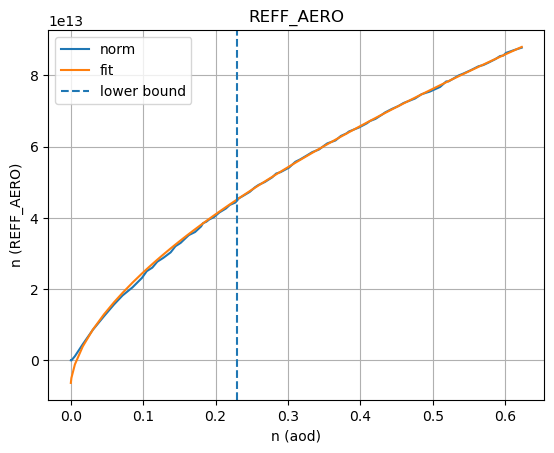

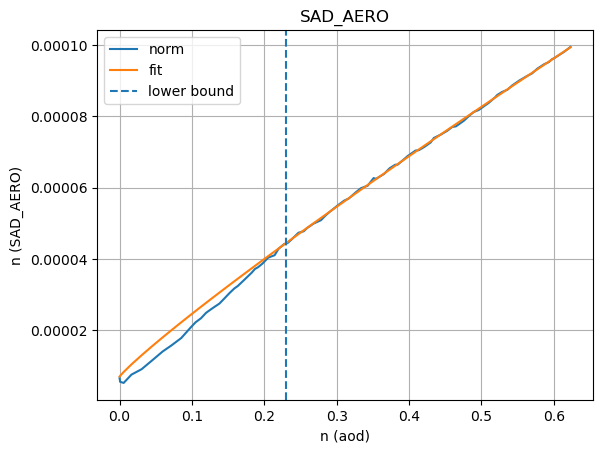

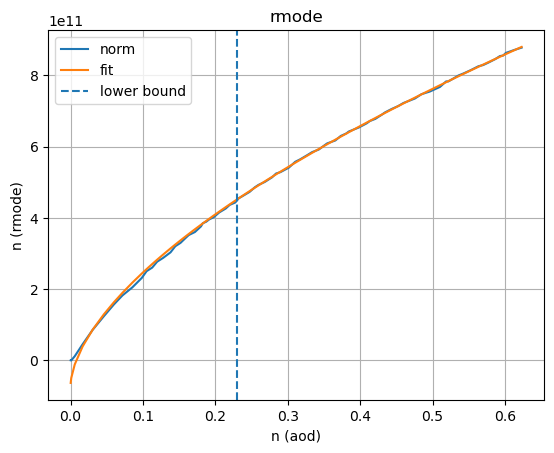

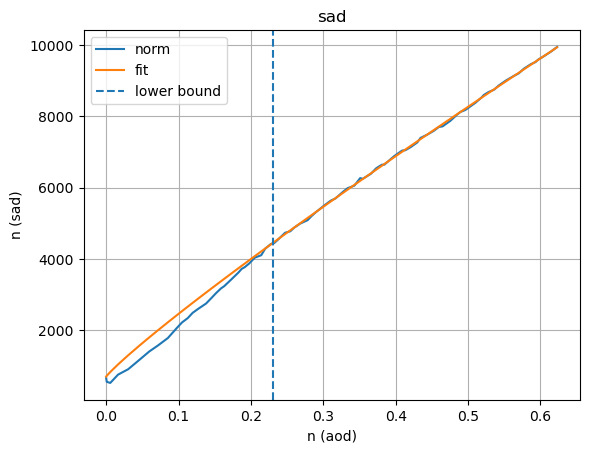

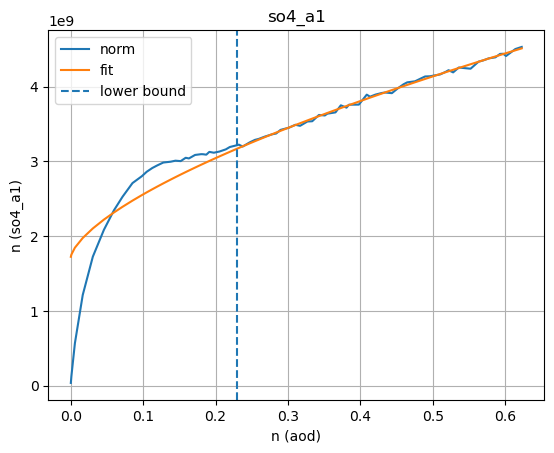

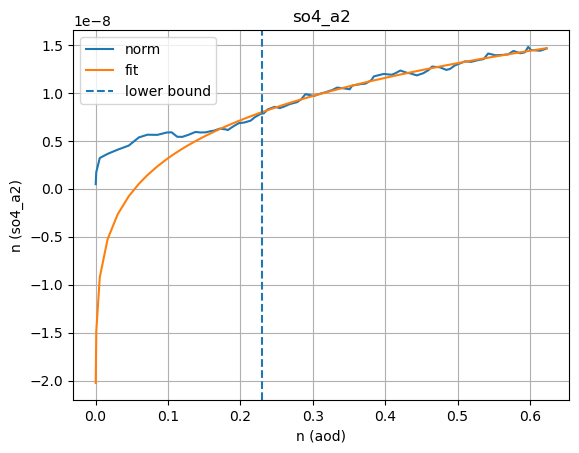

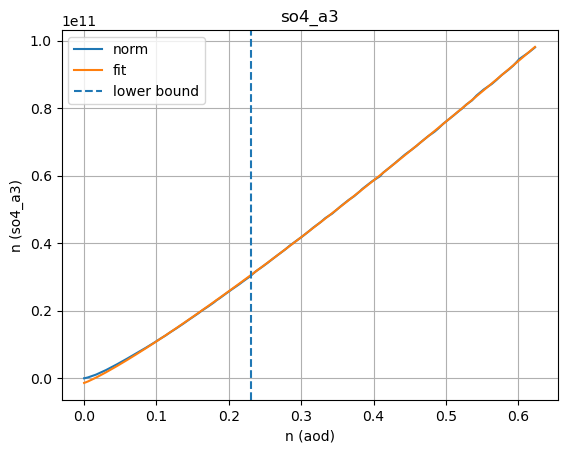

In [23]:
# show fits

for name in sorted(fit_dict):
    n_aod = exp_fields_dict['AODVISstdn']['n']
    plt.plot(n_aod, exp_fields_dict[name]['n'], label='norm')
    a,b,c = fit_dict[name]['popt']
    plt.plot(n_aod, a+b*n_aod**c, label='fit')
    plt.gca().axvline(0.23, linestyle='--', label='lower bound') # data with lower AOD not included in fit
    plt.title(name)
    plt.legend()
    plt.xlabel('n (aod)')
    plt.ylabel(f'n ({name})')
    plt.grid()
    plt.show()

In [24]:
savepath = "./fit_params_jasper_02/" # edit file path
nc.save_fit(fit_dict, savepath, options=options)

In [25]:
import pickle

fit_consts_path = "./fit_params_jasper_02/"

with open(f'{fit_consts_path}params.pkl','rb') as save_file:
    fit_params = pickle.load(save_file)
with open(f'{fit_consts_path}fit_options.pkl','rb') as save_file:
    fit_options = pickle.load(save_file)
fit_results = {name:{**fit_params[name],**fit_options[name]} for name in fit_params}

for result in fit_results['H2SO4_mass']:
    print(result+': [ c0, c1, c2 ]' if result=='popt' else result)
    for name in sorted(fit_results):
        print(f"{name:10}: {fit_results[name][result]}")
    print()

popt: [ c0, c1, c2 ]
H2SO4_mass: [-3.16490727e+26  1.38754083e+29  1.16797461e+00]
H2SO4_mmr : [7.77615898e+08 1.97858396e+11 1.13329203e+00]
REFF_AERO : [-6.66015324e+12  1.25928805e+14  6.03564698e-01]
SAD_AERO  : [6.90016881e-06 1.42043172e-04 9.05755643e-01]
rmode     : [-6.66015265e+10  1.25928805e+12  6.03564703e-01]
sad       : [6.90017122e+02 1.42043170e+04 9.05755680e-01]
so4_a1    : [1.71717957e+09 3.81491279e+09 6.56064609e-01]
so4_a2    : [-3.04225049e-08  4.86393083e-08  1.60519311e-01]
so4_a3    : [-1.37374205e+09  1.70837673e+11  1.14287289e+00]

pcov
H2SO4_mass: [[ 3.18908028e+53 -1.95400343e+52  7.47921822e+24]
 [-1.95400343e+52  5.00827202e+52 -1.57321974e+22]
 [ 7.47921822e+24 -1.57321974e+22  1.79793077e-04]]
H2SO4_mmr : [[ 1.45172548e+17 -1.89306155e+16  2.25138704e+06]
 [-1.89306155e+16  2.11997158e+16 -1.75319513e+05]
 [ 2.25138704e+06 -1.75319513e+05  3.57333532e-05]]
REFF_AERO : [[ 4.64509389e+24 -3.75538598e+24  3.83871117e+10]
 [-3.75538598e+24  3.05770228e+2